# Getting the data

In [112]:
import pandas as pd

import re 
import string

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.sparse

from sklearn.feature_extraction import text

import nltk
from nltk.util import ngrams
import spacy
from nltk.tokenize import word_tokenize, sent_tokenize,RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
df_train = pd.read_csv('file:///C:/Users/BereketSharew/Desktop/drugsComTrain_raw.tsv',sep='\t')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
Unnamed: 0     161297 non-null int64
drugName       161297 non-null object
condition      160398 non-null object
review         161297 non-null object
rating         161297 non-null float64
date           161297 non-null object
usefulCount    161297 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 8.6+ MB


In [4]:
df_test = pd.read_csv('file:///C:/Users/BereketSharew/Desktop/drugsComTest_raw.tsv',sep='\t')

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 7 columns):
Unnamed: 0     53766 non-null int64
drugName       53766 non-null object
condition      53471 non-null object
review         53766 non-null object
rating         53766 non-null float64
date           53766 non-null object
usefulCount    53766 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 2.9+ MB


In [6]:
# combining the two dataframes to have more datapoints
all_data= pd.concat([df_train, df_test], axis=0)


In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
Unnamed: 0     215063 non-null int64
drugName       215063 non-null object
condition      213869 non-null object
review         215063 non-null object
rating         215063 non-null float64
date           215063 non-null object
usefulCount    215063 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 13.1+ MB


In [8]:
all_data.columns

Index(['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')

In [9]:
#creating a dataframe using the only columns we need 
all_data = all_data.filter(['condition','rating','review','drugName'], axis=1)

In [10]:
#creating a dataframe for depression condition only
List= all_data['condition'].to_list()
list1 = [x for x in List if x != 'Depression']
df = all_data[~all_data['condition'].isin(list1)]

In [11]:
df.head()

,condition,rating,review,drugName
11,Depression,10.0,"""I have taken anti-depressants for years, with...",L-methylfolate
31,Depression,8.0,"""1 week on Zoloft for anxiety and mood swings....",Sertraline
44,Depression,4.0,"""my gp started me on Venlafaxine yesterday to ...",Venlafaxine
67,Depression,10.0,"""This medicine saved my life. I was at my wits...",Effexor XR
81,Depression,4.0,"""Started taking it and I slept well at night a...",Wellbutrin


In [12]:
#getting rid of the condition column
df = df.drop(['condition'], axis=1)

In [13]:
df = df.reset_index(drop = True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12164 entries, 0 to 12163
Data columns (total 3 columns):
rating      12164 non-null float64
review      12164 non-null object
drugName    12164 non-null object
dtypes: float64(1), object(2)
memory usage: 285.2+ KB


In [15]:
#remove duplicate reviews
df.drop_duplicates(subset=['review'], inplace=True)

In [16]:
df.isna().sum()

rating      0
review      0
drugName    0
dtype: int64

In [120]:
data_drugs = df.to_csv(r'C:/Users/BereketSharew/Desktop/data_drugs.csv',index =False)


# Document preprocessing

In [17]:
#check for missing values and remove them
df.isnull().sum()

rating      0
review      0
drugName    0
dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7112 entries, 0 to 12162
Data columns (total 3 columns):
rating      7112 non-null float64
review      7112 non-null object
drugName    7112 non-null object
dtypes: float64(1), object(2)
memory usage: 222.2+ KB


In [19]:
from num2words import num2words
def clean_text(text1):
    text1 = text1.lower() # change text to lowercase
    text1 = re.sub('[^\w\s]','',text1) # remove punctuations
    text1 = re.sub('\n','',text1)
    text1 = re.sub('\w*\d\w*','',text1)
    return text1
txt= lambda x: clean_text(x)

In [20]:
df['review_clean'] =df['review'].apply(txt)

In [21]:
df.head()

,rating,review,drugName,review_clean
0,10.0,"""I have taken anti-depressants for years, with...",L-methylfolate,i have taken antidepressants for years with so...
1,8.0,"""1 week on Zoloft for anxiety and mood swings....",Sertraline,week on zoloft for anxiety and mood swings i ...
2,4.0,"""my gp started me on Venlafaxine yesterday to ...",Venlafaxine,my gp started me on venlafaxine yesterday to h...
3,10.0,"""This medicine saved my life. I was at my wits...",Effexor XR,this medicine saved my life i was at my wits e...
4,4.0,"""Started taking it and I slept well at night a...",Wellbutrin,started taking it and i slept well at night an...


In [22]:
#lemmatizaion
nlp = spacy.load("en_core_web_sm")
def lemmatizer(text):        
    new = []
    doc = nlp(text)
    for word in doc:
        new.append(word.lemma_)
    return " ".join(new)
    
df['review_clean'] = df.apply(lambda x: lemmatizer(x['review_clean']), axis = 1)

In [26]:
corpus = df['review_clean']

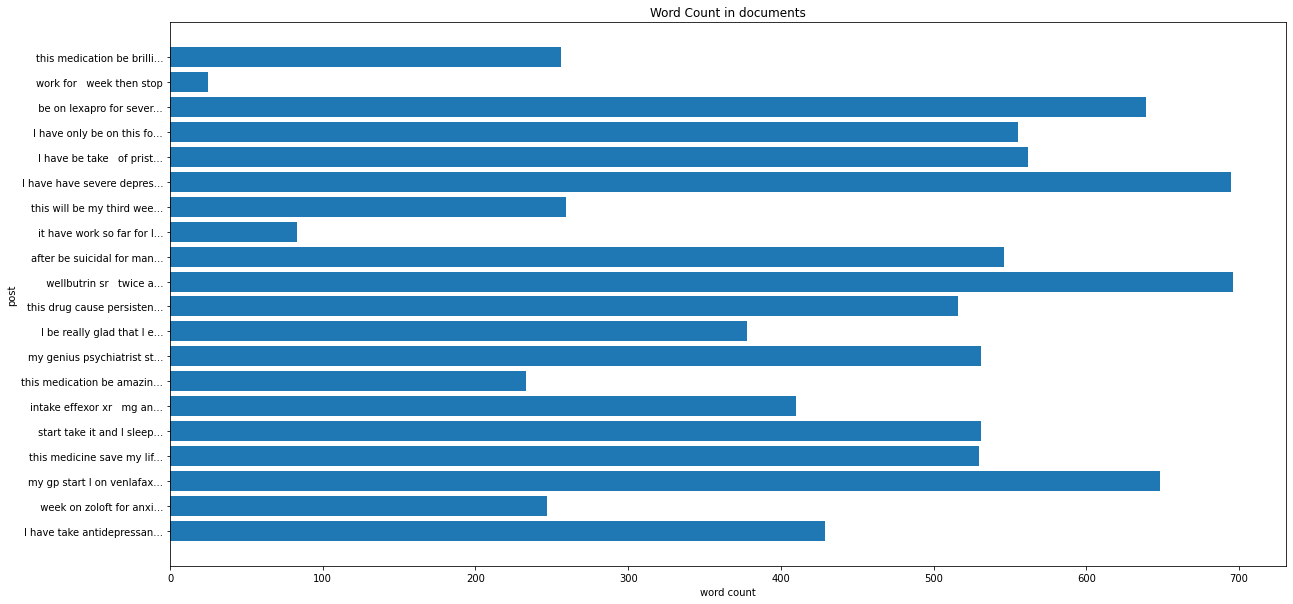

In [27]:
#word count per document in corpus
word_count = []
labels = []

for txt in corpus:
    word_count.append(len(txt))

for txt in corpus:
    if len(txt) > 50:
        txt = txt[0:25] + '...'
    labels.append(txt)

plt.figure(figsize=(20,10))
plt.title('Word Count in documents')
plt.barh(labels[0:20], word_count[0:20])
plt.xlabel('word count')
plt.ylabel('post');
#plt.savefig('word_count.png', dpi=300, bbox_inches='tight');

# Document-Term Matrix

In [28]:
tfidf = TfidfVectorizer( stop_words='english')

doc_term = tfidf.fit_transform(corpus)

vocab = tfidf.get_feature_names()

dtm = pd.DataFrame(doc_term.toarray(),index = labels, columns=vocab)

In [29]:
dtm.head()

,aa,aampe,aarp,ab,abandon,abate,abdominal,abilfyand,abilify,ability,...,zoo,zopiclone,zopliclone,zoplicone,zpot,zyban,zyprexa,zyprexai,zyprexia,zzzquil
I have take antidepressan...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
week on zoloft for anxi...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
my gp start I on venlafax...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
this medicine save my lif...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
start take it and I sleep...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA

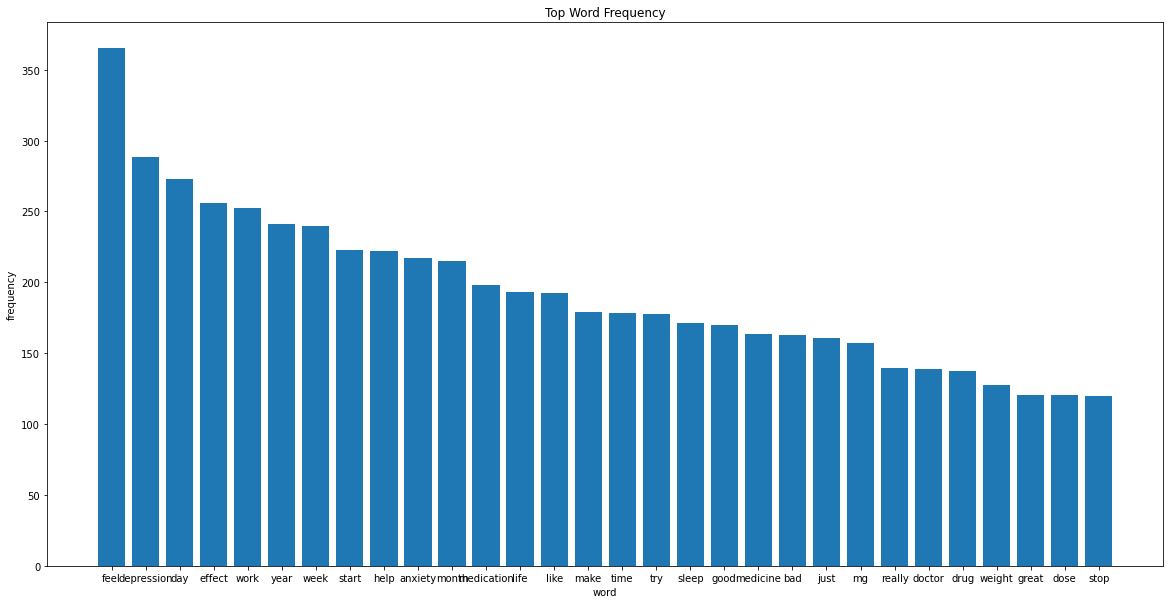

In [30]:
#frequency of top 20 words in corpus
freq = list(dtm.sum(axis=0).sort_values(ascending=False))
col_labels = list(dtm.sum(axis=0).sort_values(ascending=False).index)

plt.figure(figsize=(20,10))
plt.title('Top Word Frequency')
plt.bar(col_labels[0:30], freq[0:30])
plt.xlabel('word')
plt.ylabel('frequency');
#plt.savefig('word_freq.png', dpi=300, bbox_inches='tight');

In [74]:
# Data cleaning 2 
#taking all the frequently used but not useful words 
list_words = ['depression','like','just','really','life', 'did','effects','day','week','work','start','month','time','make','bad','good','doctor','drug','medication','help','try','right','say','antidepressant','medicine','effect','feel','want','think','thing','word','notice','great','stop','dream','mean']
#adding our list to stop words
new_stop_words = text.ENGLISH_STOP_WORDS.union(list_words)
#new document_term_matrix
cv = CountVectorizer(stop_words=new_stop_words)
cv_data =cv.fit_transform(corpus)
dtm = pd.DataFrame(cv_data.toarray(),index = labels, columns=cv.get_feature_names())


In [75]:
dtm.head()

,aa,aampe,aarp,ab,abandon,abate,abdominal,abilfyand,abilify,ability,...,zoo,zopiclone,zopliclone,zoplicone,zpot,zyban,zyprexa,zyprexai,zyprexia,zzzquil
I have take antidepressan...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
week on zoloft for anxi...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
my gp start I on venlafax...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
this medicine save my lif...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
start take it and I sleep...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


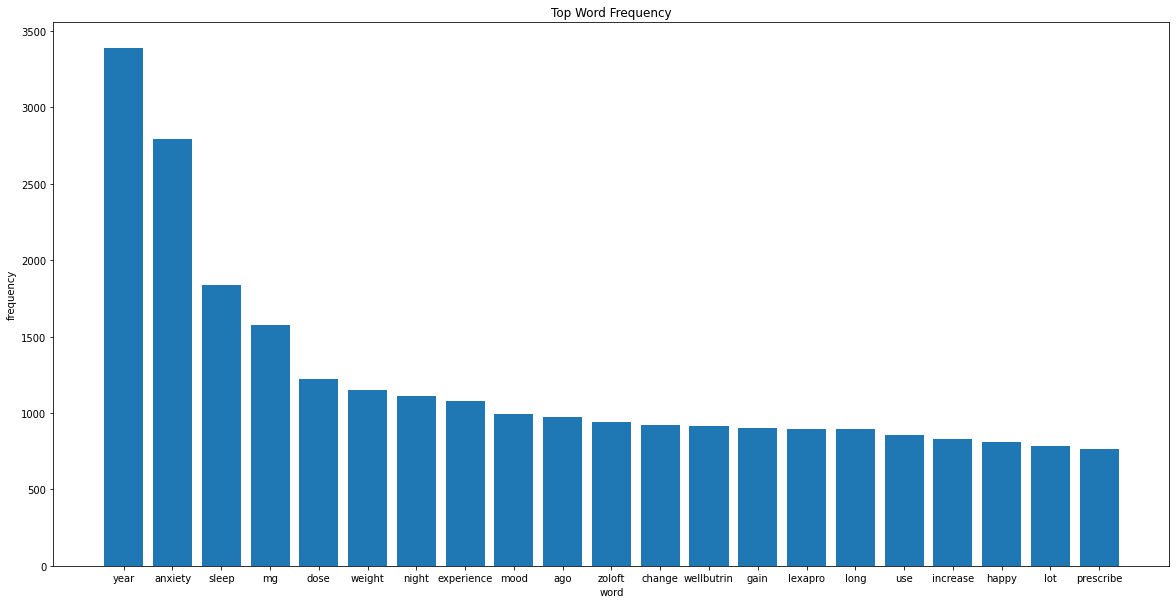

In [76]:
#frequency of top 20 words in corpus
freq = list(dtm.sum(axis=0).sort_values(ascending=False))
col_labels = list(dtm.sum(axis=0).sort_values(ascending=False).index)

plt.figure(figsize=(20,10))
plt.title('Top Word Frequency')
plt.bar(col_labels[0:21], freq[0:21])
plt.xlabel('word')
plt.ylabel('frequency');
#plt.savefig('word_freq.png', dpi=300, bbox_inches='tight');

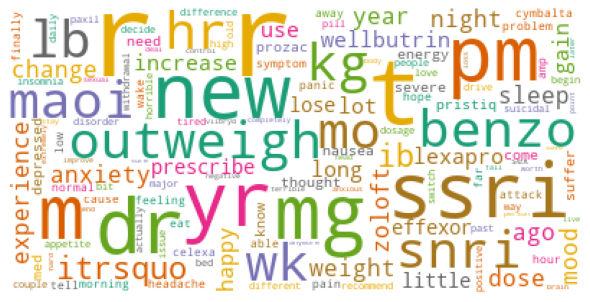

In [77]:
from wordcloud import WordCloud

split_title = [x.split(" ") for x in df['review_clean'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()
wc = WordCloud(stopwords=new_stop_words, background_color="white", colormap="Dark2", max_font_size=80, random_state=42,
              min_font_size = 5).generate((listCounts[listCounts > 2]).to_string())

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show();

# NMF

In [38]:
#new document term matrix excluding the most frequent words
tfidf = TfidfVectorizer(max_df = .8, stop_words=new_stop_words)

doc_term = tfidf.fit_transform(corpus)

vocab = tfidf.get_feature_names()

dtm = pd.DataFrame(doc_term.toarray(),index = labels, columns=vocab)

In [39]:
nmf = NMF(n_components=20, random_state = 42)

nmf.fit(doc_term)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=20, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [40]:
doc_topic_matrix = nmf.transform(doc_term)

In [41]:
doc_topic_matrix_df = pd.DataFrame(doc_topic_matrix).add_prefix('topic_')
doc_topic_matrix_df[['review','review_clean','rating']] = df[['review','review_clean','rating']]


In [42]:
doc_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,review,review_clean,rating
0,0.021367,0.000000,0.000000,0.000000,0.003568,0.010721,0.002269,0.000000,0.000000,0.001263,...,0.013352,0.003352,0.038456,0.000000,0.019039,0.002218,0.008754,"""I have taken anti-depressants for years, with...",I have take antidepressant for year with some ...,10.0
1,0.000000,0.000000,0.008018,0.000000,0.037477,0.037653,0.000059,0.000000,0.049573,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.058668,0.000000,0.000000,"""1 week on Zoloft for anxiety and mood swings....",week on zoloft for anxiety and mood swing I ...,8.0
2,0.000000,0.000000,0.043524,0.000000,0.000000,0.042125,0.000628,0.000000,0.000272,0.000000,...,0.000000,0.002125,0.062005,0.000000,0.000000,0.001783,0.000000,"""my gp started me on Venlafaxine yesterday to ...",my gp start I on venlafaxine yesterday to help...,4.0
3,0.004801,0.000000,0.000000,0.002564,0.011709,0.010841,0.000000,0.066691,0.003653,0.000997,...,0.005855,0.002076,0.000000,0.005015,0.008691,0.001216,0.000000,"""This medicine saved my life. I was at my wits...",this medicine save my life I be at my wit end ...,10.0
4,0.004383,0.000569,0.057177,0.004911,0.006009,0.004805,0.002852,0.003326,0.000054,0.002150,...,0.004114,0.002595,0.005350,0.001108,0.000000,0.008650,0.000000,"""Started taking it and I slept well at night a...",start take it and I sleep well at night and aw...,4.0


In [43]:
doc_topic_matrix_df['positive']=(doc_topic_matrix_df['rating']>5).astype(int)

In [44]:
doc_topic_matrix_df.groupby('positive').mean()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,rating
positive,,,,,,,,,,,,,,,,,,,,,
0,0.009018,0.011141,0.016031,0.010555,0.013568,0.012712,0.006571,0.006958,0.005299,0.007272,...,0.007999,0.015752,0.009461,0.006632,0.010729,0.007164,0.013016,0.005651,0.007736,2.445585
1,0.009179,0.012068,0.016322,0.010906,0.014229,0.013468,0.007528,0.007233,0.005482,0.007681,...,0.009201,0.015802,0.009626,0.006629,0.011100,0.006404,0.013933,0.005949,0.007549,8.798532


In [123]:
topic_rating = doc_topic_matrix_df.groupby('positive').mean()

In [124]:
topic_rating = topic_rating.to_csv(r'C:/Users/BereketSharew/Desktop/TR.csv',index =False)

In [435]:
#doc_topic_matrix_df.tail()

In [45]:
term_topic_matrix_df = pd.DataFrame(nmf.components_, columns=vocab).T.add_prefix('topic_')
term_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
aa,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00288,0.0,0.0,0.0,0.0,0.0,0.002839,0.001819,0.000000,0.000000,0.00792,0.002682,0.000000,0.0
aampe,0.0,0.0,0.000000,0.000000,0.005364,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.001513,0.000000,0.00000,0.000000,0.009181,0.0
aarp,0.0,0.0,0.000000,0.001066,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000353,0.000286,0.0
ab,0.0,0.0,0.000000,0.000000,0.000145,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.001999,0.000000,0.000000,0.001152,0.00000,0.000000,0.000000,0.0
abandon,0.0,0.0,0.000138,0.000000,0.000210,0.001478,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.004399,0.000350,0.00000,0.000000,0.000000,0.0


In [46]:
doc_topic_matrix_df['drugName']=df['drugName']

In [92]:
dn = doc_topic_matrix_df.drop(['rating','positive'],axis=1)

In [98]:
dn.groupby('drugName').mean().idxmax(axis=1)


drugName
Abilify                              topic_2
Alprazolam                           topic_2
Amitriptyline                        topic_3
Amitriptyline / chlordiazepoxide     topic_3
Amoxapine                           topic_12
                                      ...   
Wellbutrin SR                        topic_1
Wellbutrin XL                        topic_2
Xanax                                topic_2
Zoloft                               topic_2
Zyprexa                              topic_2
Length: 101, dtype: object

In [109]:
dn.groupby('drugName').mean().sort_values(by= 'drugName')

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
drugName,,,,,,,,,,,,,,,,,,,,
Abilify,0.009419,0.007636,0.023960,0.007125,0.011385,0.012364,0.003912,0.008316,0.008338,0.004557,0.006773,0.006699,0.016984,0.005146,0.003967,0.012722,0.007889,0.014617,0.004906,0.014234
Alprazolam,0.013762,0.011932,0.019040,0.004864,0.010498,0.010834,0.007425,0.007597,0.003607,0.002484,0.007189,0.004875,0.014784,0.015565,0.006432,0.008883,0.005850,0.013032,0.003898,0.010990
Amitriptyline,0.007796,0.004190,0.015939,0.019205,0.015468,0.012265,0.013267,0.006697,0.006265,0.005436,0.007244,0.007483,0.015298,0.008441,0.007480,0.009560,0.010647,0.013373,0.002172,0.002537
Amitriptyline / chlordiazepoxide,0.000410,0.002261,0.017047,0.112630,0.001543,0.020361,0.000000,0.002231,0.000775,0.001094,0.003052,0.029328,0.006533,0.002958,0.019535,0.002827,0.000060,0.000783,0.000564,0.000000
Amoxapine,0.000000,0.013363,0.012119,0.032338,0.025109,0.010644,0.024034,0.002368,0.000000,0.000000,0.000000,0.000000,0.045541,0.001751,0.000157,0.005684,0.000650,0.016799,0.000312,0.006010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wellbutrin SR,0.010127,0.020022,0.015403,0.018226,0.015517,0.015780,0.006973,0.003348,0.005358,0.001221,0.001229,0.007962,0.017235,0.006726,0.008547,0.007064,0.010714,0.018327,0.007528,0.008140
Wellbutrin XL,0.008008,0.007734,0.016059,0.006354,0.012937,0.012906,0.010619,0.003978,0.004890,0.004294,0.008139,0.008848,0.014172,0.015929,0.001116,0.009609,0.004085,0.015811,0.005305,0.002951
Xanax,0.009541,0.014351,0.024880,0.005846,0.010847,0.017636,0.012798,0.008833,0.006003,0.010952,0.006957,0.012263,0.013977,0.008336,0.001981,0.019256,0.004467,0.016825,0.006288,0.006725


In [122]:
dn = dn.to_csv(r'C:/Users/BereketSharew/Desktop/dn.csv',index =False)

# Topic interpretation

In [53]:
def top_review(doc_topic_matrix_df, topic, n_doc):
    return (doc_topic_matrix_df
            .sort_values(by=topic,ascending=False)
            .head(n_doc)['review_clean']
            .values)

def top_words(term_topic_matrix_df, topic, n_words):
    return (term_topic_matrix_df
            .sort_values(by=topic,ascending=False )
            .head(n_words))[topic]

In [54]:
for review in top_review(doc_topic_matrix_df, 'topic_0', 10):
    print(review)
    print()

I use to experience severe panic attack every single day until I decide to see a doctor   have not have a single attack since I start on pristiq   good antidepressant I have ever take

 mend give viibryd a try

I have suffer from major depression since childhood and have have fibromyalgia since     try effexor paxil elavil zoloft lexapro wellbutrin nortriptyline prozac and on and on all make my depression bad and leave I so tired I   function   I promise she that I   quit take it because of side effect and without talk to her first   three week I have have it but my husband keep encourage I and my doctor be out of town   week all the side effect super super fatigue dizziness nausea stomach cramp yawn no appetite have disappear and I feel fabulous emotionally and physically give it time if   have little success with other antidepressant   this one work for I

I take sertraline for depression and anxiety and while it work well it also give I insomnia and my jaw shake a lot during the day

In [55]:
top_words(term_topic_matrix_df, 'topic_0', 10)

year         4.311037
ago          1.148694
old          0.676257
suffer       0.414945
finally      0.360101
different    0.306550
severe       0.268612
use          0.260990
prescribe    0.238723
past         0.233736
Name: topic_0, dtype: float64

In [ ]:
topic_0 = length of time on medications

In [492]:
for review in top_review(doc_topic_matrix_df, 'topic_1', 15):
    print(review)
    print()

nan

"This medicine almost killed me. Symptoms worst at 40 mg but there earlier. I ended up in the ER twice and was admitted to the hospital for days after a month with uncontrollable diarrhea, vomiting and the worse abdominal cramps I&#039;ve ever had before anyone realize it was the Viibryd.  I pass kidney stones regularly, so I have a super high pain tolerance and the lower abdominal pain from Viibryd was as bad if not worse than that.  I had uncontrollable leg and body spasms and agitation and anxiety through the roof.  Tapering off the stuff ended up being just as bad, every time I took the tapered dose I felt like I was taking poison and I would go into convulsions. less serious side effects including, eye pain, odd vaginal discharg"

"I have been taking Effexor 300mg for 2 years, and it has saved my life. I didn&#039;t care if I died prior to taking it. I never get sleepy or tired, and I can concentrate much better than I used too. My depression is gone."

"Abilify has been a mi

In [493]:
top_words(term_topic_matrix_df, 'topic_1', 10)

weight      1.762007
gain        1.658055
lose        0.440316
pound       0.309419
lbs         0.298358
eat         0.256638
cause       0.156947
abilify     0.140607
loss        0.137275
appetite    0.128481
Name: topic_1, dtype: float64

topic_1 = weight gain

In [113]:
for review in top_review(doc_topic_matrix_df, 'topic_2', 15):
    print(review)
    print()

I think viibryd be a pretty good medicine   be on so many different antidepressant   always concerned about weight gain as a side effect because that to be completely honest would make I not take it however this be really good in that aspect and the only side effect   have be diarrhea the first   day of take it

I be prescribe the generic form of prozac and at   week my depression become more severe I begin feel hopeless bad I have feel in a very long time   glad to hear that most people find improvement but want to share my experience

nan

I have be on pristiq for almost   month   I be very hesitant at first but be desperate for something to help with anxiety depression and mood swing it have work wonder and my family agree the first week be hard but after that only minor side effect most of which have disappear completely I be a different person now and so very grateful

nan

the drug remove some of the empty   feel lonely feeling about life as well as intrusive wincing thought   I 

In [114]:
top_words(term_topic_matrix_df, 'topic_2', 10)

sleep       1.809648
night       1.081629
wake        0.475164
hour        0.461472
morning     0.317017
tired       0.275863
fall        0.224669
asleep      0.220346
bed         0.213335
insomnia    0.161432
Name: topic_2, dtype: float64

In [542]:
for review in top_review(doc_topic_matrix_df, 'topic_3', 15):
    print(review)
    print()

this medication give I my life back I could actually get out of my room and do life like a normal person but with a lot more energy than most people this be definitely not for people with anxiety which be why I take it with buspar but my focus be extremely sharp and I be able to just nail through daily task like a pro and feel really good about it

I start take cymbalta   month ago   I know that they say this medicine can take about   week to kick in however I feel relief within hour of take it   maybe   some medical miracle or my body finally get what it need   I be a well educate woman who have a rough childhood   I try different antidepressant over the year and never feel anything like this   I stop have suicidal thought   the side effect be loss of appetite and so tired that I have to lay down in the afternoon   the only other medication I take be birth control   I discover the follow   if I take my birth control at night before bed and the   cymbalta in the morning then   not tire

In [541]:
top_words(term_topic_matrix_df, 'topic_3', 10)

mg          2.374369
increase    0.150117
dosage      0.143050
daily       0.108979
abilify     0.105251
ago         0.079478
need        0.070212
cut         0.069408
yr          0.066848
morning     0.063460
Name: topic_3, dtype: float64

topic_2 = sleep

In [540]:
for review in top_review(doc_topic_matrix_df, 'topic_4', 15):
    print(review)
    print()

I too be excited at first to try it   it be great the first month with the exception of very vivid dream sometimes nightmare   I would often wake cry   I feel great but then read these review I find that my recent mood change have be because of this medication   I have be blame pm on everything but everything get on my nerve my dog bark the clicking of their nail on the floor even my kid eat and of course my husband   do anything right   I be very pleased with the medication at first   feel like a new person but now I see that the way I have be feel could be because of the viibryd   it   even dawn on I   I wish I have read these review soon I be go to contact my doctor today

nan

nan

I be recently put on wellbutrin by the   psychiatrist   I just start it yesterday and I feel great   the thing that I use to dwell be not on my mind   I wake up early this morning for work and I never do that   I smile today and I feel like have new adventure and not concentrate on thing that make I upse

In [497]:
top_words(term_topic_matrix_df, 'topic_4', 10)

anxiety       2.554383
suffer        0.315568
disorder      0.277345
social        0.262545
severe        0.262514
prescribe     0.184269
increase      0.149549
med           0.146993
insomnia      0.134292
generalize    0.107591
Name: topic_4, dtype: float64

Topic_4 = Anxity

In [498]:
for review in top_review(doc_topic_matrix_df, 'topic_5', 15):
    print(review)
    print()

"Been taking Brintellix for 2 weeks and so far feeling pretty good. I&#039;m a little worried about the weight gain and the price. I finally find something that works for me and it causes these side affects and ridiculous how pricey it is to feel normal! Sad to know that if I can&#039;t afford it or it puts weight on me that I&#039;m going to have to stop taking a drug that actually helps! I work out 4 days a week and had lost 22 lbs but I&#039;ve gained 4 in 2 weeks.Not acceptable! I will continue taking for another 2 weeks and see what happens!"

nan

"Wellbutrin made me a bit dizzy when I first began to take it, but on the long term it helped me quite a lot with my motivational problems and depression. I am on a 300mg dose."

"Wellbutrin is the best antidepressant that I have taken. I have tried other medications: Effexor, Celexa, Lexapro and although they took away my bad depression, they left me feeling just okay. I also had weight gain and sexual side effects. Effexor also caused

In [499]:
top_words(term_topic_matrix_df, 'topic_5', 10)

nausea        1.475862
headache      0.984773
experience    0.809506
mouth         0.553833
dry           0.551636
away          0.434043
diarrhea      0.422610
stomach       0.415769
severe        0.370127
pain          0.366768
Name: topic_5, dtype: float64

topic_5 = nausea

In [500]:
for review in top_review(doc_topic_matrix_df, 'topic_6', 15):
    print(review)
    print()

"I&rsquo;ve been dealing with a lot lately that is out of my control and have admittedly been depressed most of my life (I am 29 years old). A breakup reeked havoc on my mental health and I consulted a psychiatrist. Was prescribed generic 37.5mg for 2 weeks then was instructed to double dose. 
First pill took around 11am yesterday, by 2pm I was nauseous, dry heaving, had incredibly bad diarrhea, double vision, back pain, and was becoming very lethargic. My jaw was clenched most of the day and I was grinding my teeth all night. I didn&rsquo;t sleep well, woke up pacicking and having racing thoughts. 
Doctor said to quit taking it. One pill was enough. Never again."

"I&#039;ve been on Bupropion XL 150mg for a little over a month.  Though my depressive symptoms have subsided, I&#039;m noticing an inability to lose weight as well as some very bizarre side effects such as rapid breast growth.  (No, I am not currently pregnant.) While I am noticing an increased elated mood and a decrease in

In [501]:
top_words(term_topic_matrix_df, 'topic_6', 10)

pristiq      2.382604
hope         0.140399
suffer       0.106746
long         0.089362
normal       0.088938
morning      0.083046
appetite     0.076611
switch       0.071374
effective    0.065941
need         0.061607
Name: topic_6, dtype: float64

In [502]:
for review in top_review(doc_topic_matrix_df, 'topic_7', 15):
    print(review)
    print()

nan

"Very bad side effects:nausea, vomiting, dizziness, odd dreams.

Ended up x 2 in the ER because of this drug."

"I have been on Venlafaxine XR for 8 years (first effexor xr then generic w/o problems). started at 150, then plateaued after about a year, went up to 225 and plateaued again. I have been on 300mg dose for over 5 years. I like this rx a lot. I haven&#039;t tried other antidepressants, I was started on this because it worked for other family members. I know it&#039;s a high dose n some people are shocked, but I find this offensive and more or less stigma about mental illness and meds. I started Adderall about 4 years ago and that combination has been incredible for my depression (and ADHD). My sex drive recovered 3 months into VFX. The only compliant is when I miss a dose, in which case I have a LOT of complaints: migraines, dizzy, tremor, hypersomnia"

"Medication along with 100 mg of pristiq made me feel great until the weight came on. Getting off rexulti to see if it h

In [503]:
top_words(term_topic_matrix_df, 'topic_7', 10)

effexor       2.428572
xr            0.682136
withdrawal    0.574115
symptom       0.285748
paxil         0.229634
horrible      0.175241
come          0.156729
sweat         0.125645
miss          0.125623
zap           0.115715
Name: topic_7, dtype: float64

Topic_7 = 

In [504]:
for review in top_review(doc_topic_matrix_df, 'topic_8', 15):
    print(review)
    print()

"Good Med! Little skeptical about helping me. I have a bad habit of changing my dosages on my own. I find 200mg to be good. I take Latuda as well which is a anti-depressant booster sort of. Appetite is normal sometimes not as bad as I thought. No vomiting but diarrhea instead. I have a bad gall bladder which needs to be removed maybe why I&#039;m so loose on the stool. Stick with it."

"2 thumbs up!"

"I&#039;m on 200 mg of Zoloft and it has changed my life!"

"I am currently 21 years old, but started taking Pristiq a few years ago. I had previously tried Prozac, then Effexor, but I couldn&#039;t see much of a difference. Once I started taking Pristiq 50mg, I felt the results within the same week. It was great. However, whenever I missed a day I would feel the adverse side effects almost immediately. Brain zaps, depersonalization, dizziness, foggy thoughts, nausea, sweating, crying spells, headaches... I eventually got off of it (I honestly don&#039;t know how) but it was a very diffic

In [505]:
top_words(term_topic_matrix_df, 'topic_8', 10)

zoloft       3.394693
switch       0.187261
sexual       0.164733
paxil        0.147242
zombie       0.090037
prescribe    0.089568
tired        0.077956
wean         0.077827
hope         0.071695
viibryd      0.069431
Name: topic_8, dtype: float64

topic_8 = drug

In [506]:
for review in top_review(doc_topic_matrix_df, 'topic_9', 15):
    print(review)
    print()

nan

"I have been on 10mg a day for only a few days yet I already feel worlds better. I am feeling a lot of side effects such as the occasional headache, a sore throat, some dizziness, and some nausea, but it&#039;s all worth it for how much better I feel."

"I&#039;ve been using Maprotiline for ten years. I think it&#039;s the best antidepressant out there but since it&#039;s not new it&#039;s not being prescribed."

"I have had clinical depression since I was a young child. I am now almost 24 and I don&#039;t think I&#039;ve ever been happy, for more than a few weeks at a time, in my entire life. I have been on Zoloft and Wellbutrin in the past that did not help at all. I have been on Brintellix for a little over 6 months now and it has changed my life. I&#039;m a better wife, mother and a significantly better college student. For the first time in my life I feel alive. There are no longitudinal studies on this new drug which makes me nervous. Side effects were severe for about 3 wee

In [507]:
top_words(term_topic_matrix_df, 'topic_9', 10)

prozac          2.187710
switch          0.206185
paxil           0.102173
helpful         0.055035
prescribe       0.050046
return          0.048887
saver           0.048775
tired           0.045169
psychiatrist    0.042700
eventually      0.042062
Name: topic_9, dtype: float64

In [508]:
for review in top_review(doc_topic_matrix_df, 'topic_10', 15):
    print(review)
    print()

"I have been on many anti depressants and by far...Prozac gave me my life back. I am bi polar with PTSD and anxiety. I did lose weight and that was okay. I can sleep and am a happy woman again. I take 20mg each morning. I do not need a benzo for anxiety any longer oh and I am 33 years old. After fifteen years of Zoloft, lexapro, Paxil, Effexor, wellbutrin, you name it, I&#039;ve been on it for long periods, changed to Prozac 6 months ago, I have my life back."

"I started this 4 weeks ago. I was originally on Paxil but I was tired of its side effects. My doctor switched me to Wellbutrin after also trying Cipralex, Effexor and Zoloft.  It works great. I had almost no side effects when I started it (I did with every other medicine). It does increase anxiety for me though. Wellbutrin gives me more energy and makes me feel alive again. Because of the energy, I work out now which helps counter act the anxiety. It did not increase my sex drive BUT it made me normal. (Paxil made it so I would

In [509]:
top_words(term_topic_matrix_df, 'topic_10', 10)

cymbalta        2.370642
pain            0.540798
suffer          0.172480
withdrawal      0.159882
different       0.136251
chronic         0.128576
far             0.127724
fibromyalgia    0.114822
hope            0.112898
symptom         0.094142
Name: topic_10, dtype: float64

topic_10 = 

In [510]:
for review in top_review(doc_topic_matrix_df, 'topic_11', 15):
    print(review)
    print()

"Seems like the whole world is on antidepressants these days.  Docs doling them like candy. I was on a low dose of lexapro for years and finally got off of it (which wasn&#039;t a pleasant experience either) I might add. I had gained 20 lbs, was exhausted with no energy a mandatory 2 hr afternoon nap,  oh yeah and it zaps your libido! All things to consider. I&#039;ve switched to Wellbutrin and seem to have much less side effects."

"It saved my life.  It was the perfect medicine for me, except for chronic constipation.  Went to the hospital for the constipation (I did not know it was caused by Zoloft at the time), and they found I had appendicitis, which ruptured while I was waiting at the hospital, and also that I had kidney cancer, so got 2 surgeries, 1 for the ruptured appendicitis and 1 to take away my left kidney.  Had it not been for the Zoloft, I would be dead.  I of course had to change medicines and go the second choice prescribed by the psychiatrist.  It works, but not as we

In [511]:
top_words(term_topic_matrix_df, 'topic_11', 10)

lexapro      2.142964
switch       0.243815
sexual       0.181687
extremely    0.092433
generic      0.089210
viibryd      0.088591
normal       0.081162
tired        0.070317
ago          0.070040
insurance    0.063942
Name: topic_11, dtype: float64

topic_11 = 

In [512]:
for review in top_review(doc_topic_matrix_df, 'topic_12', 15):
    print(review)
    print()

"I&#039;m 17 female and am taking 200mg of trazodone at night for sleep purposes, and I take 100mg in the morning to help with anxieties. Trazodone really helps with anxieties, and insomnia but only on higher doses. It hasn&#039;t really helped with lifting my mood. I&#039;ve had no side effects from trazodone."

"This medicine is helping me - I feel better in general.  I have taken it for 2 weeks and gained 10lbs.  All I think about is my next meal and then snacks.  It is crazy, I can&#039;t help but eat, eat, eat.  I have called my doctor to see about switching me to something else.  I can&#039;t continue gaining weight like this. I may have to find some diet pills to off-set the cravings. If you are depressed and underweight this is the pill for you."

"On day 1 of this Cymbalta and it&#039;s awful.  I didn&#039;t sleep last night, have felt tired all day, and struggled to &quot;zone&quot; into conversations or my own thoughts.  I&#039;ve felt worried all day and have had tremors, a

In [513]:
top_words(term_topic_matrix_df, 'topic_12', 10)

thought      1.038150
depressed    0.889967
happy        0.885385
long         0.876816
lot          0.798233
suicidal     0.788130
know         0.573792
little       0.458038
normal       0.369088
people       0.361066
Name: topic_12, dtype: float64

In [514]:
for review in top_review(doc_topic_matrix_df, 'topic_13', 15):
    print(review)
    print()

"I have been depressed for a very long time. Always try so many different kind of medicines but Pristiq seems to be working great. I have already lost 12lbs in 3 weeks and I feel a lot better, with my mood swings being better. My kids have noticed a big difference in me. The only side effect was stomach was hurting but it went away. The only thing is that I feel a little down but I don&#039;t know if it&#039;s because of my PMS. I go to the doctor tomorrow and we&#039;ll see what he says but other then that I have more motivation then I ever did before. I always give up on other pills but this one seems to work. I could enjoy my life again. I just hope if they increase the dose to 100 that I will feel better and I won&#039;t be disappointed. "

"I was being prescribed different anxiety/depression drugs when Effexor stopped working. It was hell for months. Then I had the genetic blood test and found that there were only a few drugs that could work with my body. I was prescribed Pristiq 

In [515]:
top_words(term_topic_matrix_df, 'topic_13', 10)

wellbutrin    2.007278
xl            0.524872
energy        0.345606
generic       0.316389
sr            0.257672
bupropion     0.175792
sexual        0.163582
switch        0.160478
brand         0.153479
add           0.142748
Name: topic_13, dtype: float64

 Topic_13 = 

In [516]:
for review in top_review(doc_topic_matrix_df, 'topic_14', 15):
    print(review)
    print()

nan

nan

"The last medication I was on for depression completely numbed me out to the point where I had no emotions. With this medication, I am able to be happy and sad but it doesn&rsquo;t work too well to keep away the suicidal thoughts. (I am on 20mg) I wish this medication was able to make me feel happier and not constantly be fighting between happy and sad."

"I started off with 10 mg for the first week and noticed that I have FINALLY been able to get some sleep! Before hand, I could never get sleep and never had energy throughout the day. I&#039;m more friendly. I was starting to spend more time with my husband, being more intimate and just feeling good! For the second week, I started to notice my body wants to shut down by 8 pm (which I love). I could wake up 5am for work and have so much energy to get what I need done. I do not really have racing thoughts anymore. Sometimes I catch myself still being sad from time to time, but thats only be because it takes about a month to ha

In [517]:
top_words(term_topic_matrix_df, 'topic_14', 10)

attack        1.803258
panic         1.797882
xanax         0.320799
disorder      0.185198
come          0.117759
suffer        0.116120
heart         0.102819
severe        0.099268
experience    0.082752
major         0.076161
Name: topic_14, dtype: float64

In [ ]:
topic_14 = panic attack

In [544]:
for review in top_review(doc_topic_matrix_df, 'topic_15', 15):
    print(review)
    print()

this drug be prescribe to I for depression and anxiety but it have an unexpected effect I simply can not stop eat I eat the entire day and right after I finish eat a full meal I feel hungry as if I   eat anything so I eat again and again I have gain   kg in less than   week and I be love it people always make fun of I because   skinny I never think a psychiatric drug could fix this I be so happy when I look in the mirror olanzapine be the good drug if you be a skinny ectomorph who struggle with lack of appetite

wellbutrin be a miracle drug for I the first time I ever remember experience quotnormalquot be after I start take it   the only side effect I have be have vivid movie like dream and lose a ton of weight the dream be so great I   want to wake up and the weight loss be a dream come true  

for the past   year I have be on antidepressant long be remeron along with the depression I have have period of intense anxiety unbelievably intense to the extent that I could not stand to be h

In [545]:
top_words(term_topic_matrix_df, 'topic_15', 10)

dose        2.073731
increase    0.688330
low         0.675146
miss        0.459791
high        0.438554
dosage      0.291894
tell        0.161443
need        0.136793
small       0.136570
hour        0.133956
Name: topic_15, dtype: float64

topic_15 = dose

In [78]:
for review in top_review(doc_topic_matrix_df, 'topic_16', 15):
    print(review)
    print()

 so   where   head   determine to beat this any advice would be greatly appreciate also   be so scared of side effect especially fall deeply into this abyss of sadness and loneliness but I must prevail

nan

prozac have save my life I be unable to function normally and be very irritable I have be take it for   month and it be amazing other than not feel hungry and feel numb to thing that formerly make I irate I have have no bad side effect I be finally live only wish I have the nerve to take it   year ago I miss out on so much due to my severe depression

only be able to take this for two day second day I feel just awful similar to wellbutrin I   think my body can handle norepinephrine increase I also get painful urination that last day after I take my last pill ouch it hurt

nan

I hope this help to all the depressed people out there I have be see a psychiatrist for drug induce depression   I abuse meth vicodin coke and any other drug you can think of for year and that have leave I a 

In [79]:
top_words(term_topic_matrix_df, 'topic_16', 10)

celexa        2.107714
paxil         0.288044
difference    0.133971
tired         0.091977
switch        0.088248
viibryd       0.078877
normal        0.070457
finally       0.068883
happy         0.064801
completely    0.060911
Name: topic_16, dtype: float64

In [522]:
for review in top_review(doc_topic_matrix_df, 'topic_17', 10):
    print(review)
    print()

"At the age of 55, I found the only drug that has worked for me in 35 years, I can&#039;t even begin to explain my childhood or experiences thereafter, as soon as I could, I sought medical attention with my limited finances. Before that, all I could do was drink and have a good time. I thank God I finally was given Lexapro, (Escitalopram.) I felt relief immediately, whereas NOTHING else did, and was happy, After all the drugs I tried, I have no side effects with Lexapro. I hope this gives hope to those who have been searching. God bless you above and beyond your dreams. With LOVE."

"I&#039;ve only been on this medication for about 2 weeks. That said, I&#039;ve slept almost every day since starting it. I know sleepiness is a common side effect but this is excessive. Almost no energy throughout the day. Nonstop yawning. My depression is still there, anxiety has been better. I just feel very drained and apathetic. I&#039;ll stick with it for a while longer because I know it will take a w

In [523]:
top_words(term_topic_matrix_df, 'topic_17', 10)

change         1.469986
mood           1.320902
use            0.631433
swing          0.423586
far            0.283656
improve        0.277762
energy         0.220719
positive       0.173979
difference     0.156721
improvement    0.145346
Name: topic_17, dtype: float64

topic_17topic_17 = mood changes

In [524]:
for review in top_review(doc_topic_matrix_df, 'topic_18', 10):
    print(review)
    print()

"I was on this med for about 2 months.  During that time I started losing my hair and ended up losing quite a bit of it especially on the frontal part.  It did give me more energy but I also had a hard time keeping my anxiety in check.  I don&#039;t remember having the customary side effects and my body seemed to tolerate it quite well.  If it hadn&#039;t been for the hair loss and anxiety issues, I probably would have stayed on it.  I decided to go back on Paxil again a couple of days ago because I really had few problems with that except for weight gain if I don&#039;t watch myself."

"150 mg NuVigil does work somewhat for my depression, but the primary effects wear off after a few hours and I feel more tired than usual. It is better than any SSRI, SNRI, MAOI, atypical, or tricyclic antidepressant that I have taken."

"I LOVE Prozac. I have major depressive disorder and general anxiety disorder. I was on Lexapro for half a year, and despite not being a teen or young adult I had my fi

In [525]:
top_words(term_topic_matrix_df, 'topic_18', 10)

amp           2.147232
med           0.359404
yr            0.117328
brintellix    0.102694
dr            0.099118
pain          0.088789
wean          0.087832
new           0.080019
wait          0.078153
low           0.075563
Name: topic_18, dtype: float64

In [526]:
for review in top_review(doc_topic_matrix_df, 'topic_19', 15):
    print(review)
    print()

nan

nan

"after trying all ssri for 3 months i tried this snri and within 4 days i felt better. my depression and anxiety were reduced and after one month i m absolutely fine. it has proven to be lifesaver for me. i fully recommend it."

"I&#039;ve been on Abilify for about 2 weeks now. As most everyone else had said, this medication does miracles when it comes to fixing depression. My depression struggle of 4 years is gone. But also it comes with side effects .. It&#039;s this restless agitated feeling that just wont go away. When I sleep it seems to be better but other than that it&#039;s always really bad. My vision is also really bad but that could be because of the Seroquel XR that I&#039;m coming off of."

"Have anxiety and depression and have been on medicines for 20 years.  Have taken Paxil, Zoloft, Prozac, Wellbutrin, Lexapro. Just switched 3 weeks ago from Prozac/Wellbutrin to Brintellix with Wellbutrin.  Feel fantastic - much better mood, clear head, no anxiety. No side eff

In [527]:
top_words(term_topic_matrix_df, 'topic_19', 10)

sex         1.505128
drive       1.394850
decrease    0.204343
viibryd     0.203911
lose        0.192868
orgasm      0.164789
increase    0.151262
energy      0.147799
lack        0.125425
low         0.110947
Name: topic_19, dtype: float64

Topic_19 = sex drive